## 요약

 "=============" line을 경계로 하여 

================================
* 추정 area값
* 실제 area값
* 추정 peak_number
* 실제 peak_number
* 추정 center값(최대 5개 노드)
* 실제 center값
* 추정 width값(최대 5개 노드)
* 실제 width값

=================================

을 최종 출력하였습니다.

<br>

오후 미팅 때 말씀드렸던 결과보다 확연히 좋아진 모습입니다.
성흠씨가 약간의 노가다(?)를 하여 적당한 파라미터 제한범위를 알려줘서 그것을 적용하였고,
추가적으로 세세한 로스 감소(층별로 정확한 학습)를 위해 출력층을 출력의 종류별로 나누어 총 4개의 출력층을 만들었습니다.
(area, peak_number, center, width)

또한, 추론과정에서 신경망이 label 0인 부분에 대응하는 노드에서 0에 근접한 float값(ex. 0.2123, -0.1523 등)을 출력하는데(학습이 100%가 안되므로 이는 생각해보면 당연한 현상입니다), 이를 그 동안 그대로 함수 시각화 과정에 넣었기에, 결과가 더 이상하게 잘못 해석되었음을 뒤늦게 발견했습니다.
즉, 0에 근접한 값들을 그대로 center, width 값으로 시각화 해버려서 그래프가 더 이상하게 나오는 것이었습니다.(특히, width값이 0에 근접하면 뾰족한 부분이 추가됨)

실제로 파라미터 추정값들만 비교해보면, 아주 정확하지는 않지만 어느정도 실제값을 따라가는 것을 확인할 수 있었습니다.

round등의 명령어로 0에 가까운 출력에 반올림 처리를 하고, 시각화 한다고 생각하면, 어느정도 잘 일치하는 graph를 얻을 수 있을 것으로 보입니다.

<br>

## 추가 적용한 것, 알게 된 것
1. center, width을 층별로 분리하여 출력(Functial API) => Loss를 나누어 scale별로 세세한 학습이 가능하게 함.
2. 그 동안 신경망의 추론값을 -> 시각화 하는 과정에서 실수가 있었음
(0에 근접하게 출력된 값들은 실제로 무시해야 하는데, 이를 유의미한 파라미터로 해석해버림)

## 추가 과제
1. Noise 제거하고 시작하는 부분 => Denoising AutoEncoder로 치환하여 Main_inputs층 앞에 끼워넣기.
2. Amplidute를 추가 -> 출력층에도 amplitude 출력층 추가 -> 적절한 amplitude 범위 찾아서 학습 반복하기





In [1]:
# ========== Library import ==========
import numpy as np
import random
import matplotlib.pyplot as plt
import inspect

# ========== Parameter Maxtrix generation ==========
N = 5  # Maximum number of possible peak
Data_size = 200000 

Parameters = np.zeros((Data_size, N, 2))  # Set of Parameters ready
print(Parameters.shape[1])

5


In [2]:
# ========== Definition of Lorentzian function ==========
def Lorentzian(x, *args):
    '''returns sum of Multi-Lorentzian functions
    corresponding to each three parameters (amplitude, mean, width)'''

    # in physics
    #amplitude = args[::3]
    mean = args[::2]
    width = args[1::2]

    result = 0
    for i in range(len(mean)):
        result +=   ( width[i]**2 / (  (x - mean[i])**2 + width[i]**2  ))

    #for xx in range(len(result)):
     #   result[xx] += 0.1 * ((np.random.rand()*2) - 1) 
        # -0.1 ~ 0.1 noise
    return result

In [3]:
# ========== X-domain range ==========
x = np.arange(-2, 7, 0.01)
print(len(x))

900


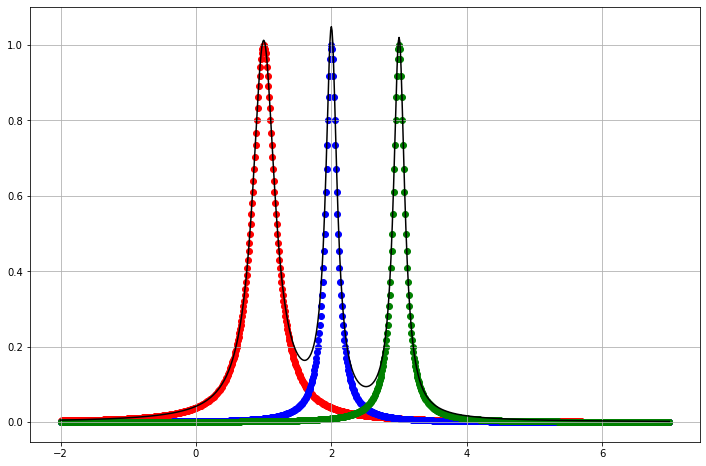

In [4]:
# ========== Checking out of the Lorentzian function ==========
params = [1, 0.2, 2,0.1,3,0.1]
plt.figure(figsize=(12, 8))
plt.plot(x, Lorentzian(x, *params), color = 'black')

plt.scatter(x, Lorentzian(x, *params[:2]), color = 'red')
plt.scatter(x, Lorentzian(x, *params[2:4]), color = 'blue')
plt.scatter(x, Lorentzian(x, *params[4::]), color = 'green')

plt.grid(True)
plt.show()


## Parameters Matrix(center, width) generation

In [5]:
# ========== Generation of Lorentzian Parameters with Matrix Form ==========

for i in range(len(Parameters)): # For each matrix in Parameter set...

    for j in range(Parameters.shape[1]): # For each raw in each matrix...
        
        # append three argument that will be used in Lorentzian function
        # amplitude = 1 ~ 5 사이의 실수
        # mean = 0 ~ 10 사이의 실수
        # width = 0.1 ~ 0.2 실수
        a = 1 + 0.5*np.random.rand() - 0.25     
        b = 2 + 0.5*np.random.rand() - 0.25
        c = 3 + 0.5*np.random.rand() - 0.25
        d = 4 + 0.5*np.random.rand() - 0.25
        e = 5 + 0.5*np.random.rand() - 0.25

        Parameters[i][0] = np.array([[ a, 0.3*np.random.rand()+0.1]])
        Parameters[i][1] = np.array([[ b, 0.3*np.random.rand()+0.1]])
        Parameters[i][2] = np.array([[ c, 0.3*np.random.rand()+0.1]])
        Parameters[i][3] = np.array([[ d, 0.3*np.random.rand()+0.1]])
        Parameters[i][4] = np.array([[ e, 0.3*np.random.rand()+0.1]])
    
# Check out
print(Parameters)

[[[1.0038751  0.24074254]
  [1.76875731 0.19268172]
  [3.05512992 0.1332568 ]
  [3.98048584 0.20680161]
  [5.22394766 0.28405249]]

 [[1.07532037 0.11480806]
  [2.02093457 0.19616565]
  [3.12052455 0.17219883]
  [4.19397898 0.25499418]
  [5.09921407 0.28967777]]

 [[0.77293254 0.26953154]
  [1.84027727 0.39498605]
  [2.90708896 0.38030061]
  [4.22099054 0.26885874]
  [5.09941327 0.30046196]]

 ...

 [[0.85699683 0.19133517]
  [2.10654701 0.17806026]
  [2.99082221 0.22772299]
  [3.88449173 0.13105118]
  [5.24751815 0.18969322]]

 [[1.10409345 0.21906828]
  [1.98849479 0.23212983]
  [3.13279417 0.20234956]
  [4.10380294 0.37673181]
  [5.04998525 0.30207846]]

 [[0.84950592 0.25585804]
  [1.75125569 0.11103825]
  [2.89514911 0.31394276]
  [4.03361136 0.29481219]
  [4.80028517 0.31400311]]]


## Dataset Generation

In [6]:
# ================== Data Generating ================
GRAPH = []  # y values of the lorentzian 
AREA_PEAK = []  # area, peak number - labels 1
CENTER = []
WIDTH = []

for j in Parameters:  # For each parameter matrix...
 
    peak = random.randint(1, N) # Random selection of Possible peak number : 1 ~ 5
    j = list(j.reshape((2*N,))) # reshape processing to put it as *args in function, Since j is matrix


    if peak == 1:
        GRAPH.append(Lorentzian(x, *j[0:2*peak]))
        AREA_PEAK.append(np.array([sum(Lorentzian(x, *j[0:2*peak])), peak]))
        CENTER.append(np.array([j[0],0,0,0,0]))
        WIDTH.append(np.array([j[1],0,0,0,0]))
        
    elif peak == 2:
        GRAPH.append(Lorentzian(x, *j[0:2*peak]))
        AREA_PEAK.append(np.array([sum(Lorentzian(x, *j[0:2*peak])), peak]))
        CENTER.append(np.array([j[0],j[2],0,0,0]))
        WIDTH.append(np.array([j[1],j[3],0,0,0]))

    elif peak == 3:
        GRAPH.append(Lorentzian(x, *j[0:2*peak]))
        AREA_PEAK.append(np.array([sum(Lorentzian(x, *j[0:2*peak])), peak]))
        CENTER.append(np.array([j[0],j[2],j[4],0,0]))
        WIDTH.append(np.array([j[1],j[3],j[5],0,0]))

    elif peak == 4:
        GRAPH.append(Lorentzian(x, *j[0:2*peak]))
        AREA_PEAK.append(np.array([sum(Lorentzian(x, *j[0:2*peak])), peak]))
        CENTER.append(np.array([j[0],j[2],j[4],j[6],0]))
        WIDTH.append(np.array([j[1],j[3],j[5],j[7],0]))

    elif peak == 5:
        GRAPH.append(Lorentzian(x, *j[0:2*peak]))
        AREA_PEAK.append(np.array([sum(Lorentzian(x, *j[0:2*peak])), peak])) 
        CENTER.append(np.array([j[0],j[2],j[4],j[6],j[8]]))
        WIDTH.append(np.array([j[1],j[3],j[5],j[7],j[9]]))

In [7]:
# conversion to numpy array
GRAPH = np.array(GRAPH)
AREA_PEAK = np.array(AREA_PEAK)
CENTER = np.array(CENTER)
WIDTH = np.array(WIDTH)

# shape check
print(GRAPH.shape)
print(AREA_PEAK.shape)
print(CENTER.shape)
print(WIDTH.shape)

(200000, 900)
(200000, 2)
(200000, 5)
(200000, 5)


## Generated Data sample check

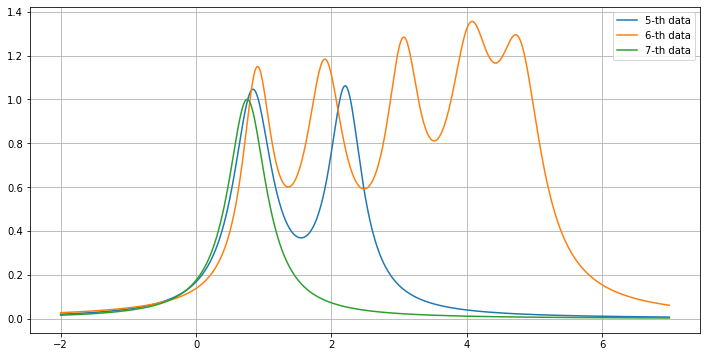

In [8]:
# ========== Generated Data sample check! ==========

plt.figure(figsize=(12, 6))
for i in range(5, 8):
    plt.plot(x, GRAPH[i], label = str(i) + '-th data')
    plt.legend()
    plt.grid('on')

## Data Spliting up => training/validation/test

In [9]:
# ========== Data spliting up into three group : training / validation / test ==========

train_data = np.array(GRAPH[:100000])
val_data   = np.array(GRAPH[100000:150000])
test_data  = np.array(GRAPH[150000:])


# sum, peak number - label1
train_labels = np.array(AREA_PEAK[:100000])
val_labels   = np.array(AREA_PEAK[100000:150000])
test_labels  = np.array(AREA_PEAK[150000:])


# amp, cen, width parameters - labels2
train_labels_center = np.array(CENTER[:100000])
val_labels_center   = np.array(CENTER[100000:150000])
test_labels_center  = np.array(CENTER[150000:])


train_labels_width = np.array(WIDTH[:100000])
val_labels_width   = np.array(WIDTH[100000:150000])
test_labels_width  = np.array(WIDTH[150000:])

In [10]:
# ========== size test ==========
print(train_data.shape, train_labels.shape, train_labels_center.shape, train_labels_width.shape)
print(val_data.shape, val_labels.shape, val_labels_center.shape, val_labels_width.shape)
print(test_data.shape, test_labels.shape, test_labels_center.shape, test_labels_width.shape)

(100000, 900) (100000, 2) (100000, 5) (100000, 5)
(50000, 900) (50000, 2) (50000, 5) (50000, 5)
(50000, 900) (50000, 2) (50000, 5) (50000, 5)


In [11]:
# reshape for Image-form setting
# 1차원일때 변환
train_data = train_data.reshape(100000, len(x), 1)
val_data = val_data.reshape(50000, len(x), 1)
test_data = test_data.reshape(50000, len(x), 1)

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(100000, 900, 1)
(50000, 900, 1)
(50000, 900, 1)


# 2. Functional API를 활용하여 비계층적 구조 신경망 작성


Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 900, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 801, 64)      6464        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 400, 64)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 400, 64)      256         max_pooling1d_1[0][0]            
____________________________________________________________________________________________

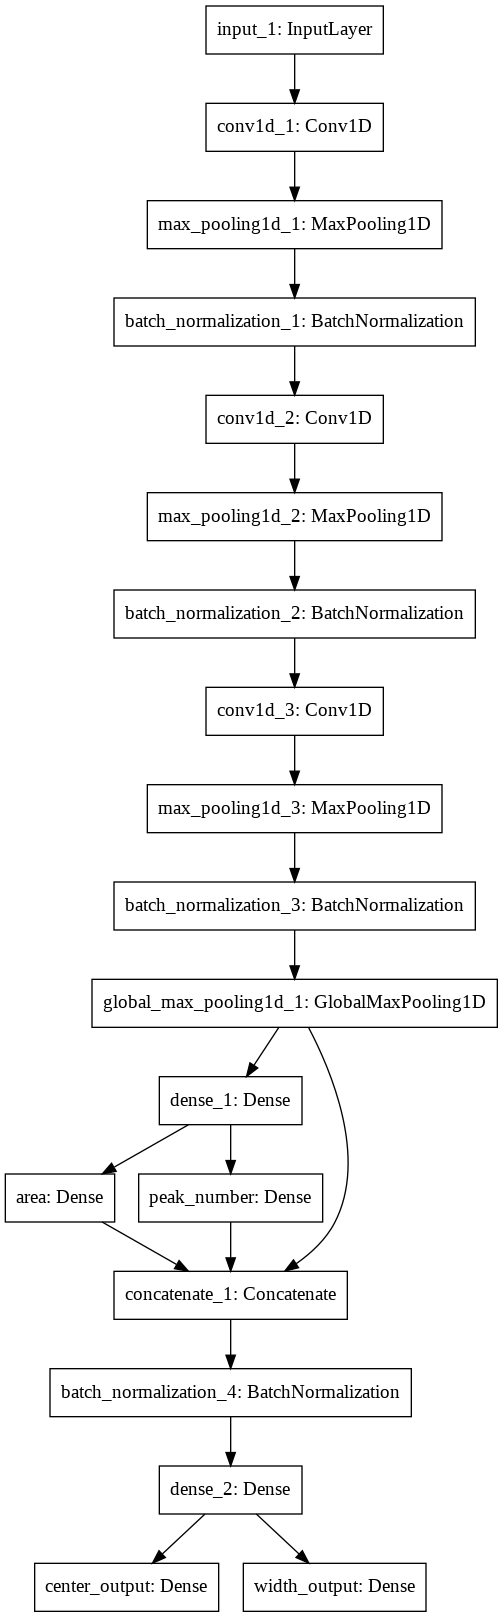

In [12]:
# Shared Input Layer
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten, BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D
from keras.layers.merge import concatenate

# input layer
main_inputs = Input(shape=(len(x), 1))

# At least three Convolution layer => other paper
# Adding BatchNormalization layer  => we expect the effect of regularization 
x_conv1 = Conv1D(64, kernel_size = 100, activation='relu')(main_inputs)
x_pooling1 = MaxPooling1D(pool_size=(2))(x_conv1)
x_batch1 = BatchNormalization()(x_pooling1)

x_conv2 = Conv1D(32, 50, activation='relu')(x_batch1)
x_pooling2 = MaxPooling1D(pool_size=(2))(x_conv2)
x_batch2 = BatchNormalization()(x_pooling2)

x_conv3 = Conv1D(16, 25, activation='relu')(x_batch2)
x_pooling3 = MaxPooling1D(pool_size=(2))(x_conv3)
x_batch3 = BatchNormalization()(x_pooling3)

# flat1 = Flatten()(pool1)
x_GMpooling = GlobalMaxPooling1D()(x_batch3)  # GlobalMaxPooling or GlobalAveragePooling or Flatten
x_dense = Dense(50, activation='relu')(x_GMpooling)

output_area = Dense(1, activation='linear', name='area')(x_dense)  # area
output_peak_number = Dense(1, activation='linear', name='peak_number')(x_dense)  # peak number

# merging features into one layer
merge = concatenate([output_area, output_peak_number, x_GMpooling])
merge2 = BatchNormalization()(merge)

hidden1 = Dense(50, activation='relu')(merge2)

# prediction output
output_center = Dense(5, activation='linear', name='center_output')(hidden1)
output_width  = Dense(5, activation='linear', name='width_output')(hidden1)
# Definition of model with one input, three output
model = Model(inputs=main_inputs, outputs=[output_area, output_peak_number, output_center, output_width])

# summarize layers
print(model.summary())
# plot graph
plot_model(model)

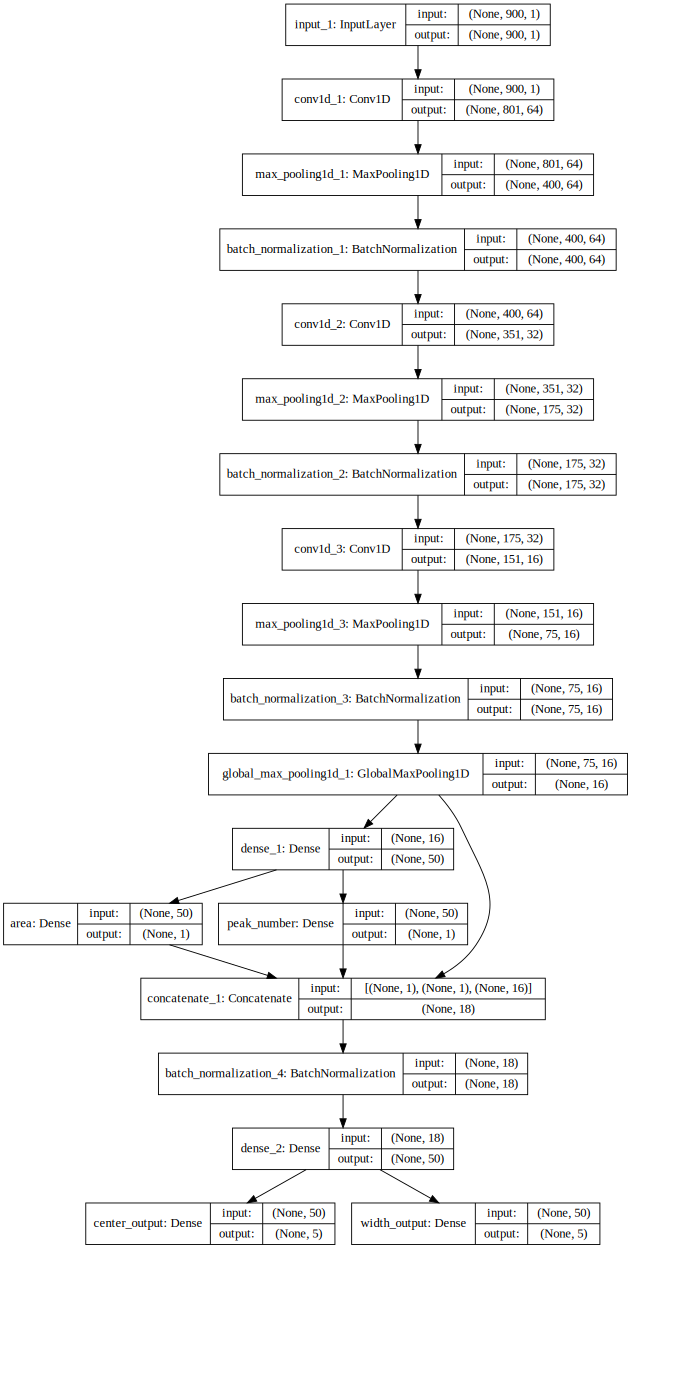

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
%matplotlib inline

SVG(model_to_dot(model, show_shapes=True, expand_nested = True, dpi = 65).create(prog='dot', format='svg'))

In [14]:
model.compile(loss=['mse', 'mse', 'mse', 'mse'], metrics=['mae'], optimizer='adam')


In [15]:
%%time
hist = model.fit(train_data, [train_labels[:,0], train_labels[:,1], train_labels_center, train_labels_width], 
                   epochs=50, 
                   batch_size=2000,
                   validation_data=(val_data, [val_labels[:,0], val_labels[:,1], val_labels_center, val_labels_width]), verbose=2)

Train on 100000 samples, validate on 50000 samples
Epoch 1/50
 - 31s - loss: 57435.0727 - area_loss: 57429.3555 - peak_number_loss: 2.0927 - center_output_loss: 3.2495 - width_output_loss: 0.3764 - area_mae: 211.6261 - peak_number_mae: 1.2259 - center_output_mae: 1.3352 - width_output_mae: 0.4699 - val_loss: 62826.3598 - val_area_loss: 62811.0586 - val_peak_number_loss: 12.0446 - val_center_output_loss: 3.0843 - val_width_output_loss: 0.1734 - val_area_mae: 223.2141 - val_peak_number_mae: 3.1228 - val_center_output_mae: 1.2452 - val_width_output_mae: 0.3409
Epoch 2/50
 - 23s - loss: 38108.5143 - area_loss: 38105.3359 - peak_number_loss: 1.3934 - center_output_loss: 1.6697 - width_output_loss: 0.1178 - area_mae: 167.2412 - peak_number_mae: 0.9254 - center_output_mae: 0.9279 - width_output_mae: 0.2690 - val_loss: 63370.1694 - val_area_loss: 63355.3984 - val_peak_number_loss: 11.0090 - val_center_output_loss: 3.6922 - val_width_output_loss: 0.0634 - val_area_mae: 224.2175 - val_peak_numbe

In [16]:
hist.history.keys()

dict_keys(['val_loss', 'val_area_loss', 'val_peak_number_loss', 'val_center_output_loss', 'val_width_output_loss', 'val_area_mae', 'val_peak_number_mae', 'val_center_output_mae', 'val_width_output_mae', 'loss', 'area_loss', 'peak_number_loss', 'center_output_loss', 'width_output_loss', 'area_mae', 'peak_number_mae', 'center_output_mae', 'width_output_mae'])

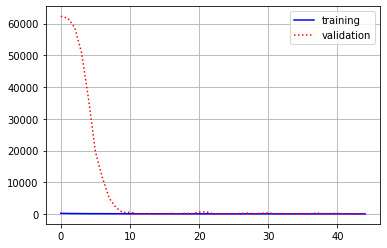

In [17]:
# Loss plot
plt.plot(hist.history['loss'][5:],     'b-', label="training")
plt.plot(hist.history['val_loss'][5:], 'r:', label="validation")
plt.grid(True)
plt.legend()
plt.show()

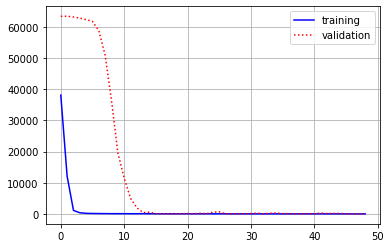

In [18]:
# Loss plot
plt.plot(hist.history['area_loss'][1:],     'b-', label="training")
plt.plot(hist.history['val_area_loss'][1:], 'r:', label="validation")
plt.grid(True)
plt.legend()
plt.show()

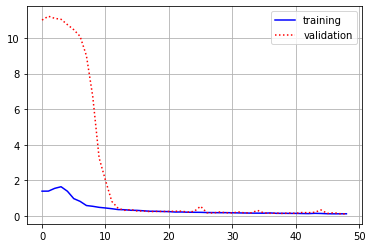

In [19]:
# Loss plot
plt.plot(hist.history['peak_number_loss'][1:],     'b-', label="training")
plt.plot(hist.history['val_peak_number_loss'][1:], 'r:', label="validation")
plt.grid(True)
plt.legend()
plt.show()

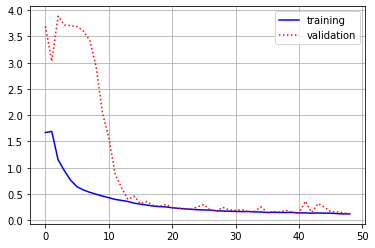

In [20]:
# Loss plot
plt.plot(hist.history['center_output_loss'][1:],     'b-', label="training")
plt.plot(hist.history['val_center_output_loss'][1:], 'r:', label="validation")
plt.grid(True)
plt.legend()
plt.show()

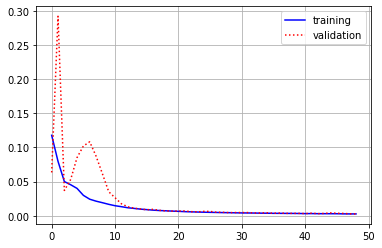

In [21]:
# Loss plot
plt.plot(hist.history['width_output_loss'][1:],     'b-', label="training")
plt.plot(hist.history['val_width_output_loss'][1:], 'r:', label="validation")
plt.grid(True)
plt.legend()
plt.show()

In [22]:
test_data.shape

(50000, 900, 1)

In [23]:
predict = model.predict(test_data)
len(predict)

4

In [24]:
print(predict[0].shape) # area
print(predict[1].shape) # peak number
print(predict[2].shape) # center
print(predict[3].shape) # width

(50000, 1)
(50000, 1)
(50000, 5)
(50000, 5)


# Test Dataset 삽입 => label parameters 추론, 비교

이전의 엉망이었던 결과와 비교하여 상당히 근접한 parameter 추정값을 보여준다.

In [25]:
for i in range(11, 25):
    print("Predicted area:", predict[0][i])
    print("True area:", test_labels[i,0])
    print("Predicted peak:", predict[1][i])
    print("True peak:", test_labels[i,1])
    print("Predicted center:", predict[2][i])
    print("True center:", test_labels_center[i])
    print("Predicted width:", predict[3][i])
    print("True width:", test_labels_width[i])
    print("==============================================================================")

    #print(predict[2][i])
    #print(test_labels_2[i])

Predicted area: [499.29013]
True area: 502.42665527243855
Predicted peak: [4.788329]
True peak: 5.0
Predicted center: [1.1576629 2.0423775 3.004804  4.071446  6.18626  ]
True center: [1.19192993 2.10738731 2.87549923 4.14398084 5.09549523]
Predicted width: [0.3741333  0.3335617  0.37246713 0.38957098 0.37505734]
True width: [0.39893162 0.33662097 0.39294631 0.29145344 0.27125351]
Predicted area: [111.889854]
True area: 109.38672970558824
Predicted peak: [1.353871]
True peak: 1.0
Predicted center: [ 1.0018293   0.38507092  0.06028886 -0.02447684  0.02135137]
True center: [1.21822528 0.         0.         0.         0.        ]
Predicted width: [0.3424523  0.03706365 0.02535823 0.02057753 0.00547005]
True width: [0.36907843 0.         0.         0.         0.        ]
Predicted area: [259.82904]
True area: 256.05469635475674
Predicted peak: [2.7877629]
True peak: 3.0
Predicted center: [0.9123789  2.1652548  3.023264   0.13899845 0.15438665]
True center: [0.99234621 2.10677409 3.1565496  

## 일단 바로 윗부분 셀까지만 실행하였음.

아래 부분은 수정이 필요합니다. 아래 부분의 시각화는 신경망 출력값을 잘못 해석하여 코드 수정이 필요함을 뒤늦게 깨달았습니다. 특히 밑의 그래프의 predict 그래프에서 x=0 근방에서 뾰족한 peak가 자주 보입니다. 이 부분은 실제로 0으로 처리되어 그려지지 않았어야 할 부분인데, 신경망 추론의 특성상 0에 가깝지만, 0은 아닌 값들이 출력되므로 이 값들을 시각화한 결과입니다. 그러나 다른 쪽 그래프의 모양은 이전에 비하면 확실히 더 나아졌음을 알 수 있습니다. 추가 코딩을 통하여 더 나아질 수 있지만, 시간이 한정되어 여기까지의 자료를 교수님께 보내드립니다.   

박형선 올림.


In [26]:
# 윗부분의 파라미터 추정은 그럴듯함..
# 0 라벨 처리된 노드에서는 추정값으로 0에 가까운 실수값이 나오고 이를 반올림 등으로 0처리하여 무시하는 기술이 필요하다.


for i in range(20):
    plt.figure(figsize=(12,5))
    plt.plot(x, Lorentzian(x, *list(predict[2][i])), label=str(i)+'-th predict')
    plt.plot(x, test_data[i], label=str(i)+'-th label')
    plt.legend()
    plt.show()
    print("pre_area:", predict[0][i])
    print("true_area:", test_labels[i, 0])
    print("pred_peak:", predict[1][i])
    print("true_peak:", test_labels[i, 1])

IndexError: ignored

<Figure size 864x360 with 0 Axes>

# 3. 고찰

거의 다 한듯?... 제한된 조건에서나마 그럴듯하게 parameter 추정할 수 있는 듯 하다.